In [33]:
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from nltk.corpus import stopwords
from datasets import load_dataset


In [38]:

# Load IMDb dataset
raw_dataset = load_dataset("imdb")
df = pd.DataFrame(raw_dataset['train'])

# Create imbalanced dataset: 9000 positive, 1000 negative
df_pos = df[df['label'] == 1]
df_neg = df[df['label'] == 0]
df_pos_bal = resample(df_pos, replace=False, n_samples=9000, random_state=42)
df_neg_bal = resample(df_neg, replace=False, n_samples=1000, random_state=42)
imbalanced_df = pd.concat([df_pos_bal, df_neg_bal]).sample(frac=1, random_state=42).reset_index(drop=True)

# Preprocess
stop_words = set(stopwords.words('english'))

# Tokenizer setup
vocab_size = 3000  # Adjust vocab size as needed
max_len = 128  # Adjust max sequence length as needed
embedding_dim = 100  # Set embedding dimension size
tokenizer = Tokenizer(num_words=vocab_size)

# Fit tokenizer on training text
X_train_text = imbalanced_df['text'].tolist()  # Using the full dataset for tokenizer fitting
tokenizer.fit_on_texts(X_train_text)

# Convert texts to sequences and pad them
X = tokenizer.texts_to_sequences(X_train_text)
X = pad_sequences(X, maxlen=max_len, padding='post')

# Extract labels
y = imbalanced_df['label'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [39]:
# Custom Deep NLP Model (LSTM) from scratch with random embeddings
class CustomLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, max_len):
        super(CustomLSTMModel, self).__init__()
        # Initialize the embedding layer with random weights
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.max_len = max_len

    def forward(self, input_ids):
        
        embedded = self.embedding(input_ids)
        
        lstm_out, _ = self.lstm(embedded)
       
        last_hidden_state = lstm_out[:, -1, :]
    
        output = self.fc(last_hidden_state)
        return output

# ModAL wrapper for Custom LSTM Model
class CustomModALWrapper:
    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device

    def predict(self, X):
        self.model.eval()
        input_ids = torch.stack([torch.tensor(x) for x in X]).to(self.device)
        with torch.no_grad():
            logits = self.model(input_ids)
            return torch.argmax(logits, dim=1).cpu().numpy()

    def predict_proba(self, X):
        self.model.eval()
        input_ids = torch.stack([torch.tensor(x) for x in X]).to(self.device)
        with torch.no_grad():
            logits = self.model(input_ids)
            return torch.softmax(logits, dim=1).cpu().numpy()

    def fit(self, X, y, epochs=3, batch_size=16):
        dataset = TensorDataset(
            torch.tensor(X),
            torch.tensor(y)
        )
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optimizer = optim.AdamW(self.model.parameters(), lr=2e-5)
        criterion = nn.CrossEntropyLoss()
        self.model.train()
        for _ in range(epochs):
            for input_ids, labels in loader:
                input_ids, labels = input_ids.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(input_ids)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()



In [44]:

def random_query_strategy(learner, X, n_instances):
    """Randomly select n_instances from X."""
    
    random_indices = np.random.choice(range(len(X)), size=n_instances, replace=False)
    return random_indices, None  

def active_learning_loop(tokenized_data, labels, n_initial=200, batch_size=32, n_rounds=5, strategy_name='uncertainty'):
    # Strategy mapping
    strategy_functions = {
        'uncertainty': uncertainty_sampling,
        'margin': margin_sampling,
        'entropy': entropy_sampling,
        'random': random_query_strategy
    }
    
    query_strategy = strategy_functions.get(strategy_name)
    
    if query_strategy is None:
        raise ValueError(f"Unknown strategy: {strategy_name}")

    indices = np.arange(len(labels))
    initial_idx = np.random.choice(indices, size=n_initial, replace=False)
    X_labeled = [tokenized_data[i] for i in initial_idx]
    y_labeled = labels[initial_idx]
    unlabeled_idx = np.setdiff1d(indices, initial_idx)
    X_unlabeled = [tokenized_data[i] for i in unlabeled_idx]
    y_unlabeled = labels[unlabeled_idx]
    
    # Model setup
    model = CustomLSTMModel(vocab_size=vocab_size, embed_dim=embedding_dim, hidden_dim=128, output_dim=2, max_len=max_len)
    wrapped = CustomModALWrapper(model)
    learner = ActiveLearner(
        estimator=wrapped,
        query_strategy=query_strategy,
        X_training=X_labeled,
        y_training=y_labeled
    )

    results = []
    for round in range(n_rounds):
        
        learner.estimator.fit(learner.X_training, learner.y_training, epochs=3)
        
        # Training accuracy
        train_pred = learner.predict(X_labeled)
        train_acc = accuracy_score(y_labeled, train_pred)
        train_f1 = f1_score(y_labeled, train_pred, average='weighted')

        # Test accuracy
        test_pred = learner.predict(X_unlabeled)
        test_acc = accuracy_score(y_unlabeled, test_pred)
        test_f1 = f1_score(y_unlabeled, test_pred, average='weighted')

       
        results.append({
            'round': round + 1,
            'train_acc': train_acc,
            'train_f1': train_f1,
            'test_acc': test_acc,
            'test_f1': test_f1
        })

        # If there's not enough data left in the pool, stop querying
        if len(X_unlabeled) < batch_size:
            print("Not enough data ")
            break

        # Query for the next batch of data
        query_idx, _ = learner.query(X_unlabeled, n_instances=batch_size)
        learner.teach(
            X=[X_unlabeled[i] for i in query_idx],
            y=[y_unlabeled[i] for i in query_idx]
        )
        for i in sorted(query_idx, reverse=True):
            del X_unlabeled[i]
            y_unlabeled = np.delete(y_unlabeled, i)

    return results


In [45]:
strategies = ['random','uncertainty', 'entropy', 'margin']

# Loop through each strategy
for strategy in strategies:
    print(f"\n Running Active Learning with strategy: {strategy.upper()}")
    
    # Run experiment for the current strategy
    results = active_learning_loop(X_train, y_train, strategy_name=strategy)
    
    # Print detailed results
    print(f"\n Results for {strategy.upper()} Strategy:")
    for r in results:
        print(
            f"Round {r['round']}: "
            f"Train ACC = {r['train_acc']:.4f}, F1 = {r['train_f1']:.4f} | "
            f"Test ACC = {r['test_acc']:.4f}, F1 = {r['test_f1']:.4f}"
        )



 Running Active Learning with strategy: RANDOM


c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprec


 Results for RANDOM Strategy:
Round 1: Train ACC = 0.5600, F1 = 0.6476 | Test ACC = 0.5532, F1 = 0.6417
Round 2: Train ACC = 0.6950, F1 = 0.7485 | Test ACC = 0.6702, F1 = 0.7312
Round 3: Train ACC = 0.7900, F1 = 0.8051 | Test ACC = 0.7879, F1 = 0.8041
Round 4: Train ACC = 0.8600, F1 = 0.8440 | Test ACC = 0.8554, F1 = 0.8376
Round 5: Train ACC = 0.9000, F1 = 0.8688 | Test ACC = 0.8870, F1 = 0.8498

 Running Active Learning with strategy: UNCERTAINTY


c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprec


 Results for UNCERTAINTY Strategy:
Round 1: Train ACC = 0.6800, F1 = 0.7280 | Test ACC = 0.6533, F1 = 0.7197
Round 2: Train ACC = 0.8100, F1 = 0.8189 | Test ACC = 0.7282, F1 = 0.7690
Round 3: Train ACC = 0.8950, F1 = 0.8733 | Test ACC = 0.8086, F1 = 0.8144
Round 4: Train ACC = 0.8900, F1 = 0.8597 | Test ACC = 0.8638, F1 = 0.8397
Round 5: Train ACC = 0.8850, F1 = 0.8356 | Test ACC = 0.8923, F1 = 0.8502

 Running Active Learning with strategy: ENTROPY


c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprec


 Results for ENTROPY Strategy:
Round 1: Train ACC = 0.7750, F1 = 0.8108 | Test ACC = 0.7455, F1 = 0.7793
Round 2: Train ACC = 0.8500, F1 = 0.8540 | Test ACC = 0.8135, F1 = 0.8168
Round 3: Train ACC = 0.9100, F1 = 0.8844 | Test ACC = 0.8649, F1 = 0.8423
Round 4: Train ACC = 0.9250, F1 = 0.8934 | Test ACC = 0.8890, F1 = 0.8502
Round 5: Train ACC = 0.9200, F1 = 0.8817 | Test ACC = 0.8982, F1 = 0.8523

 Running Active Learning with strategy: MARGIN


c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprec


 Results for MARGIN Strategy:
Round 1: Train ACC = 0.7300, F1 = 0.7786 | Test ACC = 0.7058, F1 = 0.7537
Round 2: Train ACC = 0.8350, F1 = 0.8434 | Test ACC = 0.7785, F1 = 0.7976
Round 3: Train ACC = 0.8800, F1 = 0.8653 | Test ACC = 0.8374, F1 = 0.8276
Round 4: Train ACC = 0.8850, F1 = 0.8498 | Test ACC = 0.8801, F1 = 0.8464
Round 5: Train ACC = 0.9050, F1 = 0.8599 | Test ACC = 0.8960, F1 = 0.8515



Running Active Learning with strategy: RANDOM


c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprec

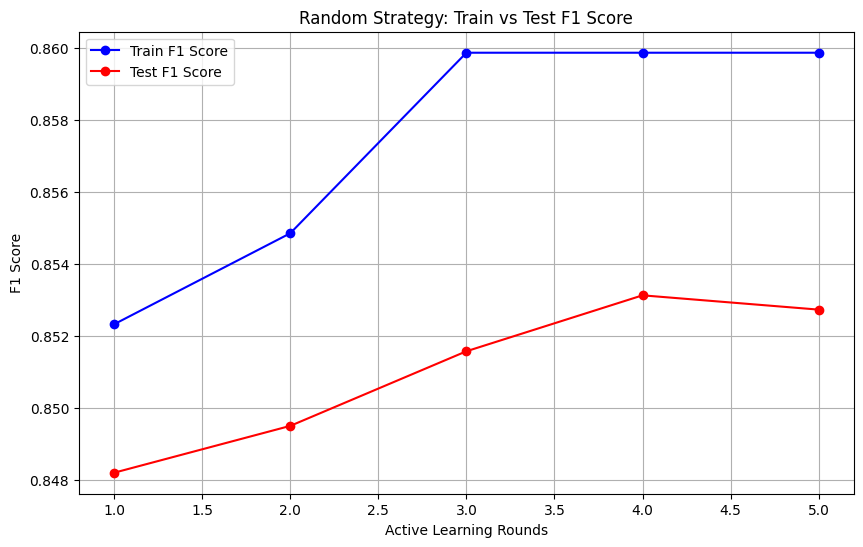


Running Active Learning with strategy: UNCERTAINTY


c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprec

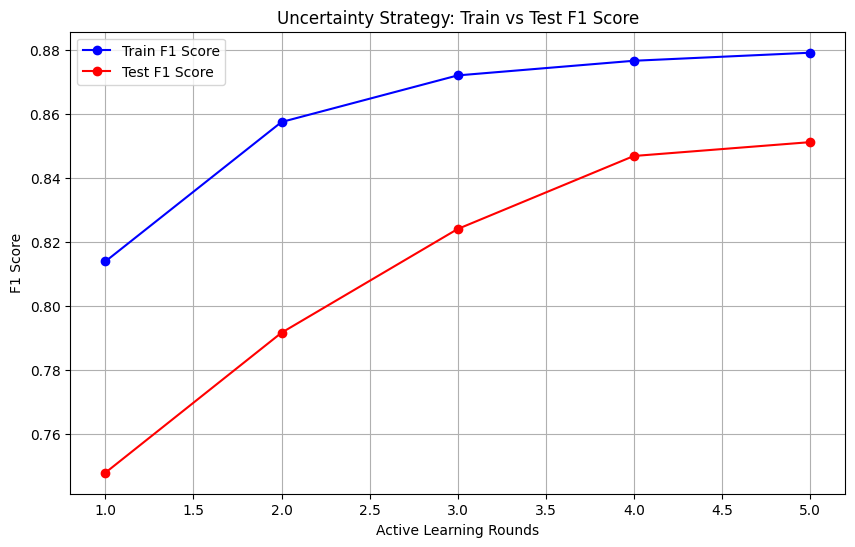


Running Active Learning with strategy: ENTROPY


c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprec

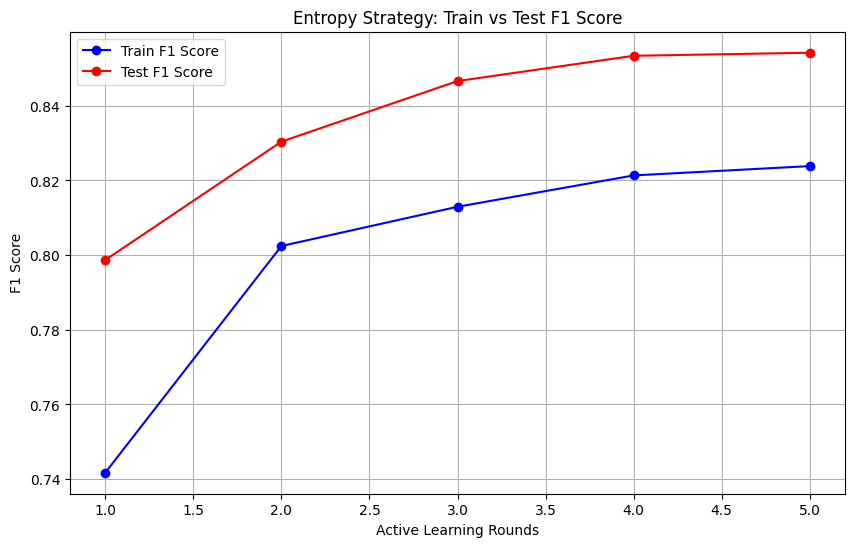


Running Active Learning with strategy: MARGIN


c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprec

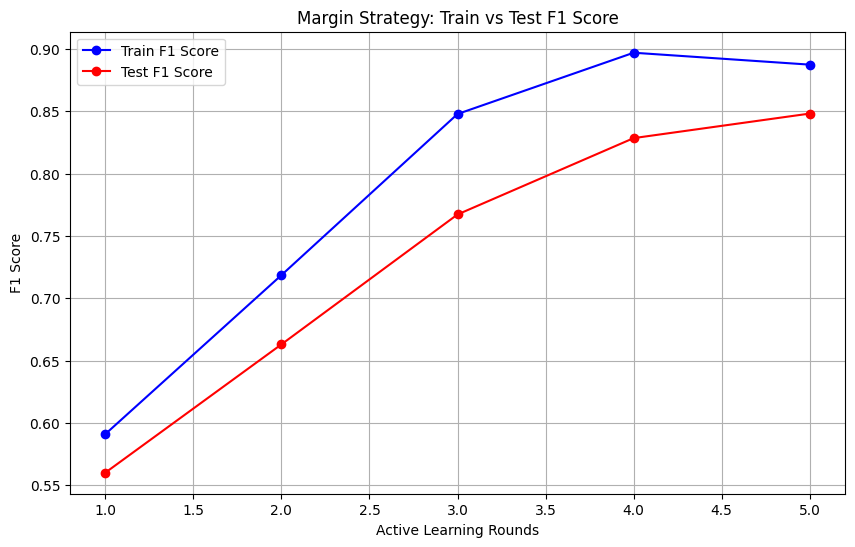

In [47]:
import matplotlib.pyplot as plt

# List of strategies to loop through
strategies = ['random', 'uncertainty', 'entropy', 'margin']

# Loop through each strategy and plot F1 scores
for strategy in strategies:
    print(f"\nRunning Active Learning with strategy: {strategy.upper()}")

    # Run active learning loop for the current strategy
    results = active_learning_loop(X_train, y_train, strategy_name=strategy)

    # Extract F1 scores for plotting
    train_f1_scores = [r['train_f1'] for r in results]
    test_f1_scores = [r['test_f1'] for r in results]
    rounds = [r['round'] for r in results]

    # Plotting the F1 scores for the current strategy
    plt.figure(figsize=(10, 6))

    # Plot train F1 score
    plt.plot(rounds, train_f1_scores, label='Train F1 Score', marker='o', color='blue', linestyle='-', markersize=6)

    # Plot test F1 score
    plt.plot(rounds, test_f1_scores, label='Test F1 Score', marker='o', color='red', linestyle='-', markersize=6)

    # Adding labels and title
    plt.xlabel('Active Learning Rounds')
    plt.ylabel('F1 Score')
    plt.title(f'{strategy.capitalize()} Strategy: Train vs Test F1 Score')
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()
